# Thesis random sweeps - 1Try - Fisher Info and characterisation plots


1/2

Vary most parameters randomly, checking usual metrics when no data is available.

Will need to filter and plot parameter effects afterwards.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import scipy as sp
import scipy.stats as spst
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.utils import io
import progress

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

In [325]:
with io.capture_output(display=False, stdout=True) as captured:
    %run reloader_fisher2016_random_large_300816.py

In [326]:
def avg_lastaxis(array_name, array):
    return [(array_name, utils.nanmean(array, axis=-1))]
def avg_twice_lastaxis(array_name, array):
    return [(array_name, utils.nanmean(utils.nanmean(array, axis=-1), axis=-1))]
def process_marginal_fi(array_name, array):
    # Marginal FI/Inv FI have (mean, std), just keep mean
    return [(array_name, utils.nanmean(array, axis=-1)[:, 0])]
def process_em_fits(array_name, array):
    emfits_all = utils.nanmean(array, axis=-1)
    outputs = [(array_name + "_" + colname, emfits_all[:, col_i])
            for col_i, colname in enumerate(['kappa',
                                             'target',
                                             'nontargets',
                                             'random',
                                             'LL',
                                             'bic'])
              ]
    outputs.append((array_name + '_fidelity', 1./utils.kappa_to_stddev(emfits_all[:, 0])**2.))
    
    return outputs
    
def construct_pandas_dataframe(data_pbs, pandas_columns_with_processing, num_repetitions):
    parameter_names_sorted = data_pbs.dataset_infos['parameters']
    filter_data = None
    result_parameters_flat = None

    pandas_column_data = []

    for result_array_name, result_processing in pandas_columns_with_processing:
        # Extract data
        res_array = np.array(data_pbs.dict_arrays[result_array_name]['results_flat'])

        # Filter completed only
        if filter_data is None:
            repeats_completed = data_pbs.dict_arrays[result_array_name]['repeats_completed']
            filter_data = repeats_completed == (num_repetitions - 1)
        res_array = res_array[filter_data]

        # Keep parameters
        if result_parameters_flat is None:
            result_parameters_flat = np.array(data_pbs.dict_arrays[result_array_name]['parameters_flat'])
            result_parameters_flat = result_parameters_flat[filter_data]

        # Transform into list of columns for Pandas
        pandas_column_data.extend(result_processing['process'](result_processing['name'], res_array))

    # Add all parameters to Pandas columns
    for param_i, param_name in enumerate(parameter_names_sorted):
        pandas_column_data.append((param_name, result_parameters_flat[:, param_i]))
    
    df_out = pd.DataFrame.from_items(pandas_column_data)
    
    # Remove NaN
    df_out = df_out.dropna()
    
    return df_out

In [354]:
# Extract data
num_repetitions = generator_module.num_repetitions
parameter_names_sorted = data_pbs.dataset_infos['parameters']
all_args_arr = np.array(data_pbs.loaded_data['args_list'])

T_space = data_pbs.loaded_data['parameters_uniques']['T']
M_space = data_pbs.loaded_data['parameters_uniques']['M']
ratio_conj_space = data_pbs.loaded_data['parameters_uniques']['ratio_conj']
sigmax_space = data_pbs.loaded_data['parameters_uniques']['sigmax']
sigmabase_space = data_pbs.loaded_data['parameters_uniques']['sigma_baseline']

pandas_columns_with_processing = [
    ('result_all_precisions', dict(name='precision', process=avg_lastaxis)),
    ('result_FI_rc_curv', dict(name='fi_curv', process=avg_twice_lastaxis)),
    ('result_FI_rc_theo', dict(name='fi_theo', process=avg_twice_lastaxis)),
    ('result_FI_rc_theocov', dict(name='fi_theo_cov', process=avg_twice_lastaxis)),
    ('result_marginal_FI', dict(name='fi_marginal', process=process_marginal_fi)),
    ('result_marginal_inv_FI', dict(name='inv_fi_marginal', process=process_marginal_fi)),
    ('result_em_fits', dict(name='emfit', process=process_em_fits)),
]

df_all_fits = construct_pandas_dataframe(data_pbs, pandas_columns_with_processing, num_repetitions)
df_all_fits.loc[:, ('T')] = df_all_fits.loc[:, ('T')].astype(int)
df_all_fits.loc[:, ('M')] = df_all_fits.loc[:, ('M')].astype(int)

In [355]:
df_all_fits.describe()

,precision,fi_curv,fi_theo,fi_theo_cov,fi_marginal,inv_fi_marginal,emfit_kappa,emfit_target,emfit_nontargets,emfit_random,emfit_LL,emfit_bic,emfit_fidelity,T,M,ratio_conj,sigmax,sigma_baseline
count,10067.000000,10067.000000,10067.000000,10067.000000,10067.000000,1.006700e+04,10067.000000,10067.000000,10067.000000,1.006700e+04,10067.000000,10067.000000,10067.000000,10067.000000,10067.000000,10067.000000,10067.000000,10067.000000
mean,46.765154,1046.246630,749.213543,748.917433,772.143051,2.074753e+15,791.449931,0.392975,0.187751,4.192740e-01,-217.812990,462.212301,790.933478,3.017880,304.514453,0.478120,0.404309,0.400679
std,926.720556,3287.567985,3386.044630,3496.430382,3488.038834,4.387671e+17,8160.463848,0.283624,0.179164,2.849014e-01,184.549807,371.324481,8160.465417,1.412976,174.367383,0.287542,0.228175,0.226886
min,0.125789,0.017295,0.000197,0.000198,0.000201,-2.516296e+19,0.321018,0.000005,0.000000,5.082966e-12,-367.462387,-1509.338355,0.271422,1.000000,4.000000,0.000000,0.010303,0.010107
25%,0.273302,32.817236,16.778459,16.524780,16.969541,1.930429e-03,11.414262,0.148403,0.048276,1.651474e-01,-340.641974,368.737914,10.893228,2.000000,152.000000,0.224377,0.206336,0.202235
50%,0.454698,193.699909,93.500756,91.815036,95.284777,1.052913e-02,49.657722,0.333295,0.141164,4.130950e-01,-293.034276,611.029975,49.153403,3.000000,303.000000,0.470588,0.403976,0.403344
75%,0.973486,1031.665505,500.283630,490.685321,515.329747,6.046161e-02,399.180794,0.599415,0.279741,6.570081e-01,-172.625170,710.212138,398.680271,4.000000,454.000000,0.725322,0.601598,0.595215
max,72519.400615,155780.291007,173425.178388,173425.178388,179621.938818,2.296964e+19,586445.519998,1.000000,0.838726,9.951281e-01,762.616653,771.971883,586445.020113,5.000000,623.000000,1.000000,0.799937,0.799892


In [367]:
# Remove outliers
df_fits_filtered = df_all_fits[np.all(np.abs(spst.zscore(df_all_fits)) < 7, axis=1)]

In [368]:
df_fits_filtered.describe()

,precision,fi_curv,fi_theo,fi_theo_cov,fi_marginal,inv_fi_marginal,emfit_kappa,emfit_target,emfit_nontargets,emfit_random,...,emfit_fidelity,T,M,ratio_conj,sigmax,sigma_baseline,M_qi,ratio_conj_qi,sigmax_qi,sigma_baseline_qi
count,10011.000000,10011.000000,10011.000000,10011.000000,10011.000000,1.001100e+04,10011.000000,10011.000000,10011.000000,1.001100e+04,...,10011.000000,10011.00000,10011.000000,10011.000000,10011.000000,10011.000000,10011.000000,10011.000000,10011.00000,10011.000000
mean,23.310484,920.301715,614.158667,609.341729,633.254734,-3.862541e+14,487.496436,0.392626,0.187537,4.198369e-01,...,486.979904,3.01838,304.235341,0.479359,0.405058,0.401655,4.484068,4.511138,4.50954,4.512436
std,259.610791,1881.977262,1641.667553,1643.560911,1694.053567,3.326216e+16,1569.246733,0.282893,0.178683,2.840864e-01,...,1569.251724,1.41261,173.987605,0.287314,0.227548,0.226485,2.868970,2.869724,2.86534,2.867629
min,0.125789,0.021683,0.000285,0.000281,0.000436,-2.141302e+18,0.321018,0.000394,0.000000,1.550608e-11,...,0.271422,1.00000,4.000000,0.000000,0.010303,0.010107,0.000000,0.000000,0.00000,0.000000
25%,0.273726,32.875227,16.789394,16.532447,16.996335,1.965144e-03,11.363679,0.148669,0.048446,1.666868e-01,...,10.842535,2.00000,152.000000,0.225806,0.208167,0.204323,2.000000,2.000000,2.00000,2.000000
50%,0.454799,192.310580,92.569739,90.640014,94.841475,1.065001e-02,48.746740,0.333295,0.141167,4.136687e-01,...,48.242338,3.00000,302.000000,0.471698,0.405190,0.404199,4.000000,5.000000,5.00000,5.000000
75%,0.968899,1015.880018,492.778815,484.590100,506.779128,6.053228e-02,388.378915,0.598220,0.279259,6.566588e-01,...,387.878376,4.00000,453.000000,0.727273,0.601598,0.595567,7.000000,7.000000,7.00000,7.000000
max,6460.877289,22519.913194,22966.321028,22853.611852,23468.712233,1.666071e+18,47424.795563,1.000000,0.838726,9.951281e-01,...,47424.295559,5.00000,623.000000,1.000000,0.799937,0.799892,9.000000,9.000000,9.00000,9.000000


## -> Some stats

In [136]:
## Correlations
df_fits_filtered.corr()

,precision,fi_curv,fi_theo,fi_theo_cov,fi_marginal,inv_fi_marginal,emfit_kappa,emfit_target,emfit_nontargets,emfit_random,emfit_LL,emfit_bic,emfit_fidelity,T,M,ratio_conj,sigmax,sigma_baseline
precision,1.000000,-0.022345,0.009394,0.010327,0.008365,0.002268,-0.022101,0.288588,-0.135774,-0.204718,0.383566,-0.384599,-0.022099,-0.151619,0.025676,0.101877,-0.161653,-0.135641
fi_curv,-0.022345,1.000000,0.962749,0.960948,0.962879,0.009088,0.622466,-0.238119,0.062577,0.198512,0.262997,-0.262608,0.622472,-0.059738,0.487631,-0.495001,-0.173512,-0.079990
fi_theo,0.009394,0.962749,1.000000,0.999774,0.999963,0.007491,0.564465,-0.094042,0.095955,0.035765,0.396202,-0.395932,0.564469,-0.102754,0.400826,-0.394863,-0.241982,-0.119950
fi_theo_cov,0.010327,0.960948,0.999774,1.000000,0.999737,0.007476,0.563796,-0.091190,0.093365,0.034490,0.398368,-0.398185,0.563800,-0.106873,0.398870,-0.394059,-0.243536,-0.116631
fi_marginal,0.008365,0.962879,0.999963,0.999737,1.000000,0.007475,0.564706,-0.094957,0.096272,0.036482,0.394860,-0.394593,0.564711,-0.102447,0.400510,-0.395157,-0.241318,-0.119507
inv_fi_marginal,0.002268,0.009088,0.007491,0.007476,0.007475,1.000000,-0.020412,0.020681,0.011765,-0.027535,0.013634,-0.014058,-0.020412,-0.021014,0.026891,0.006502,-0.005177,0.013398
emfit_kappa,-0.022101,0.622466,0.564465,0.563796,0.564706,-0.020412,1.000000,-0.236228,-0.017662,0.244657,0.080968,-0.080608,1.000000,-0.008715,0.302275,-0.370106,-0.008328,-0.025772
emfit_target,0.288588,-0.238119,-0.094042,-0.091190,-0.094957,0.020681,-0.236228,1.000000,-0.286752,-0.819331,0.705118,-0.710274,-0.236231,-0.410030,-0.057416,0.615609,-0.461006,-0.230350
emfit_nontargets,-0.135774,0.062577,0.095955,0.093365,0.096272,0.011765,-0.017662,-0.286752,1.000000,-0.314300,-0.033915,0.047483,-0.017665,0.556549,-0.378001,-0.212614,-0.279079,-0.090656
emfit_random,-0.204718,0.198512,0.035765,0.034490,0.036482,-0.027535,0.244657,-0.819331,-0.314300,1.000000,-0.678432,0.675422,0.244662,0.073246,0.283111,-0.482792,0.623844,0.282516


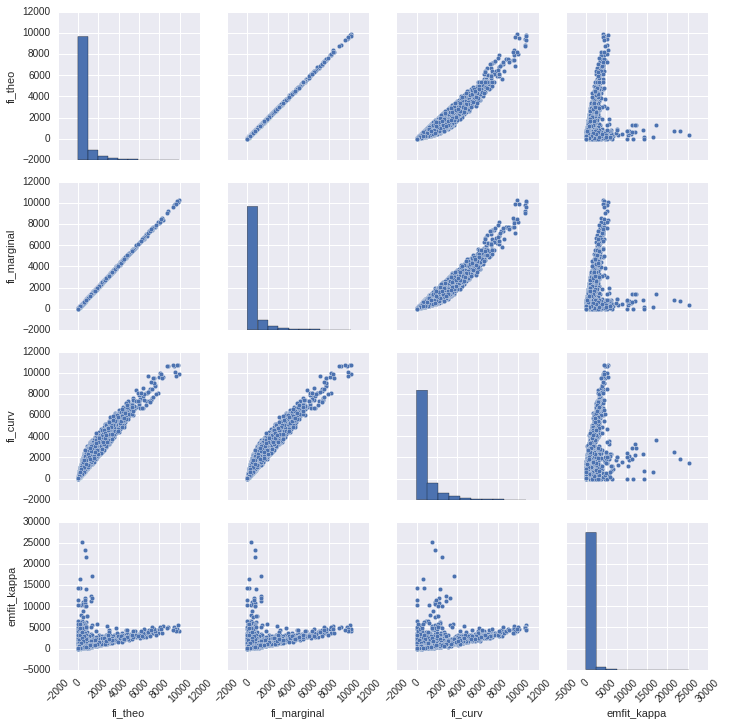

In [39]:
# Cross-correlation plots
g = sns.pairplot(df_fits_filtered,
             x_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa'],
             y_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa'],
            )
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)


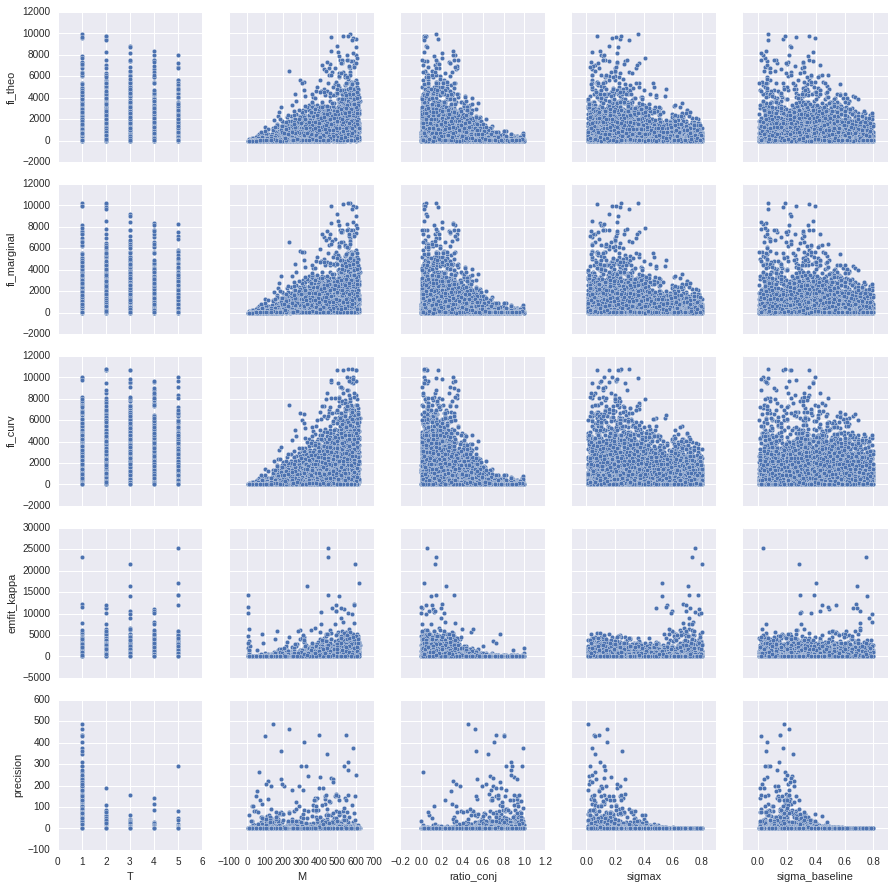

In [35]:
# Check parameters effects
sns.pairplot(df_fits_filtered,
             x_vars=parameter_names_sorted,
             y_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa', 'precision']
            )

In [41]:
# for T, subdf in df_fits_filtered.groupby('T'):
#     g = sns.pairplot(subdf,
#                  x_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa'],
#                  y_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa'],
#                 )
#     g.fig.suptitle("T : %d "% T, fontsize=30)
#     for ax in g.axes.flat:  
#         plt.setp(ax.get_xticklabels(), rotation=45)

## Quantize parameters

In [374]:
nQuantiles = 10
parameters = ['M', 'ratio_conj', 'sigmax', 'sigma_baseline']

def df_add_quantize_parameters(df, parameters, nQuantiles):
    param_qbins = dict()
    param_qbins_middle = dict()

    for param_name in parameters:
        param_factored, param_qbins[param_name] = pd.qcut(df[param_name], nQuantiles, retbins=True, labels=False)
        param_qbins_middle[param_name] = ((param_qbins[param_name][:-1] + param_qbins[param_name][1:])/2.
                                         ).astype(df[param_name].dtype)
        df.loc[:, param_name + "_qi"] = param_factored
    
    return df, param_qbins

df_quantized, param_qbins = df_add_quantize_parameters(df_fits_filtered, parameters, nQuantiles)

In [375]:
def filter_dataframe(df, parameters_values):
    filter_mask = None
    for key, value in parameters_values.iteritems():
        new_filter = (df[key] == value)
        if filter_mask is None:
            filter_mask = new_filter
        else:
            filter_mask = filter_mask & new_filter
    
    return df[filter_mask]

def filter_quantized_param(df, target_parameters, param_qbins):
    quantized_parameters_targets = dict()
    
    for key, value in target_parameters.iteritems():
        target_qi = (np.digitize(value, param_qbins[key], right=False).item() - 1)
        quantized_parameters_targets[key + "_qi"] = target_qi

    return filter_dataframe(df, quantized_parameters_targets)

### trying quantized Dataframes

In [376]:
df_lownoise = filter_quantized_param(filter_dataframe(df_quantized, dict(T=1)), 
                                     dict(sigmax=0.15, sigma_baseline=0.1), 
                                     param_qbins
                                    )

In [377]:
df_lownoise

,precision,fi_curv,fi_theo,fi_theo_cov,fi_marginal,inv_fi_marginal,emfit_kappa,emfit_target,emfit_nontargets,emfit_random,...,emfit_fidelity,T,M,ratio_conj,sigmax,sigma_baseline,M_qi,ratio_conj_qi,sigmax_qi,sigma_baseline_qi
584,1736.763348,3444.585287,3339.556725,3339.556725,3422.608439,0.000292,1737.263487,1.000000,0.0,6.923522e-10,...,1736.763367,1,259,0.467181,0.118540,0.134140,4,4,1,1
1026,1150.556828,2857.241307,2800.401753,2800.401753,2873.479487,0.000348,1151.057016,1.000000,0.0,4.002701e-10,...,1150.556834,1,163,0.153374,0.148650,0.122887,2,1,1,1
1033,43.398962,97.502890,95.868976,95.868976,99.338366,0.010067,43.903787,1.000000,0.0,3.254374e-09,...,43.398883,1,86,0.744186,0.120111,0.122291,1,7,1,1
1344,58.909579,125.362833,123.181206,123.181206,120.932149,0.008269,59.413144,1.000000,0.0,2.914177e-09,...,58.909552,1,111,0.729730,0.103402,0.146200,1,7,1,1
1531,53.724431,118.290583,115.593631,115.593631,120.901286,0.008272,54.228409,1.000000,0.0,3.275138e-09,...,53.724464,1,80,0.800000,0.091550,0.116964,1,8,1,1
1767,0.639252,2.371448,1.781712,1.781712,1.427852,0.700355,1.450464,0.845230,0.0,1.547705e-01,...,0.928575,1,10,0.400000,0.125340,0.108191,0,4,1,1
2115,1591.399067,3398.319102,3320.831153,3320.831153,3405.409026,0.000294,1591.900619,1.000000,0.0,5.440000e-08,...,1591.400488,1,426,0.600939,0.159214,0.094437,7,6,1,1
3500,199.326441,471.458798,459.654640,459.654640,468.375422,0.002135,199.827510,1.000000,0.0,1.559218e-09,...,199.326460,1,206,0.699029,0.103073,0.116378,3,7,1,1
4202,5935.831606,12319.317539,12585.311244,12585.311244,12964.355019,0.000077,5936.331642,1.000000,0.0,2.282163e-11,...,5935.831607,1,416,0.471154,0.108102,0.098460,6,4,1,1
4225,46.199192,97.231176,94.118940,94.118940,92.666430,0.010791,46.704264,0.999999,0.0,7.809486e-07,...,46.199663,1,135,0.896296,0.162675,0.152983,2,9,1,1


In [378]:
df_lownoise[['fi_theo', 'emfit_kappa', 'emfit_target', 'M', 'ratio_conj']].corr()

,fi_theo,emfit_kappa,emfit_target,M,ratio_conj
fi_theo,1.000000,0.997042,0.157191,0.516347,-0.486606
emfit_kappa,0.997042,1.000000,0.160818,0.524436,-0.491338
emfit_target,0.157191,0.160818,1.000000,0.301998,0.104554
M,0.516347,0.524436,0.301998,1.000000,0.087149
ratio_conj,-0.486606,-0.491338,0.104554,0.087149,1.000000


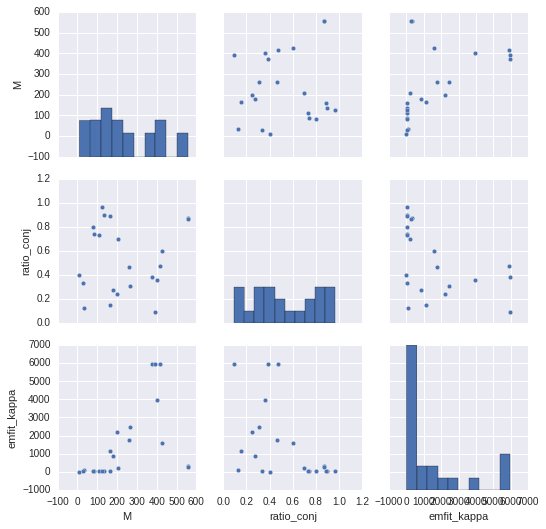

In [379]:
sns.pairplot(df_lownoise,
             vars=['M', 'ratio_conj', 'emfit_kappa']
            )

# ==> Not enough datapoints...

Use 2try instead, fixing sigmax and sigma_baseline